In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
imsize = 224
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()
])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/style/scream.jpg")
content_img = image_loader("./data/content/gold_bridge.jpg")

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(tensor):
    num, channel, height, width = tensor.size()
    feature = tensor.view(num*channel, height*width)
    
    G = torch.mm(feature, feature.t())
    
    return G.div(num*channel*height*width)

In [7]:
class StyleLoss(nn.Module):
    
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()
    
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self, input):
        return (input - self.mean) / self.std

In [10]:
content_layers_default = ['relu_6']
style_layers_default = ['relu_1','relu_3','relu_5','relu_9','relu_13']
style_layers_num = len(style_layers_default)
def get_model(cnn, mean, std, style_img, style_layers, content_img, content_layers):
    
    vgg = copy.deepcopy(cnn)
    
    
    normalization = Normalization(mean, std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        
        
        model.add_module(name, layer)
        
        if name in content_layers:
            
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
        
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i], StyleLoss) or isinstance(model[i], ContentLoss):
            break
    model = model[:(i+1)]
    
    return model, style_losses, content_losses

In [11]:
model, style_loss, content_loss = get_model(vgg19, vgg_normalization_mean, vgg_normalization_std, style_img, style_layers_default,
                                           content_img, content_layers_default)

In [12]:
print(model)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (style_loss_1): StyleLoss()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (style_loss_3): StyleLoss()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (style_loss_5): StyleLoss()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (content_loss_6): ContentLoss()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

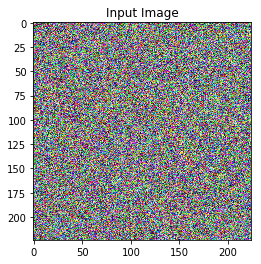

In [13]:
input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [14]:
optimizer = optim.LBFGS([input_img.requires_grad_()])
style_weight = 2000000
content_weight = 1

In [20]:
run = [0]
while run[0] < 300:
    def closure():
        
        input_img.data.clamp_(0,1)
        
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0
        for sl in style_loss:
            style_score += sl.loss * (1.0/style_layers_num)
        for cl in content_loss:
            content_score += cl.loss
        
        style_score *= style_weight
        content_score *= content_weight
        
        loss = style_score + content_score
        
        loss.backward()
        
        run[0] += 1
        if run[0] % 50 == 0:
            print('run {}: '.format(run[0]))
            print('content loss: {:4f} |  style loss: {:4f}'.format(content_score.data.item(), style_score.data.item()))
            print()
        
        return style_score + content_score
    
    optimizer.step(closure)

input_img.data.clamp_(0,1)

run 50: 
content loss: 6.942473 |  style loss: 3.313301

run 100: 
content loss: 6.932630 |  style loss: 3.337453

run 150: 
content loss: 6.941835 |  style loss: 3.380959

run 200: 
content loss: 7.776796 |  style loss: 3.991526

run 250: 
content loss: 7.017632 |  style loss: 3.520697

run 300: 
content loss: 6.839554 |  style loss: 3.385379



tensor([[[[1.0000, 0.2030, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 0.7282,  ..., 0.2739, 0.3713, 0.0387],
          [1.0000, 0.7230, 0.9281,  ..., 0.0384, 0.0774, 0.1135],
          ...,
          [0.4769, 0.8225, 0.8635,  ..., 0.9349, 0.2822, 0.5035],
          [0.3754, 0.3931, 1.0000,  ..., 0.7701, 0.6992, 0.2880],
          [0.4218, 0.5866, 0.7092,  ..., 1.0000, 0.9671, 0.3230]],

         [[1.0000, 0.9770, 0.4253,  ..., 0.0185, 0.5853, 0.1088],
          [0.6980, 0.5067, 0.2951,  ..., 0.0000, 0.1440, 0.1911],
          [0.6180, 1.0000, 0.6787,  ..., 0.2490, 0.2953, 0.0351],
          ...,
          [0.5793, 0.3748, 0.3950,  ..., 0.1223, 0.3666, 0.6357],
          [0.7162, 0.4241, 0.4168,  ..., 0.0000, 0.4395, 0.6133],
          [0.7029, 0.1878, 0.8389,  ..., 0.0000, 0.4231, 0.3261]],

         [[0.0003, 0.0000, 0.0000,  ..., 0.4867, 0.0239, 0.2394],
          [0.4966, 0.7633, 0.9717,  ..., 0.5122, 0.0896, 0.2327],
          [0.0956, 0.0000, 0.3130,  ..., 0

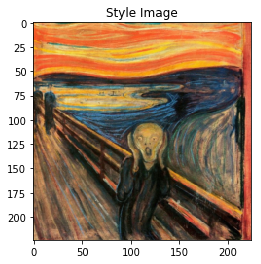

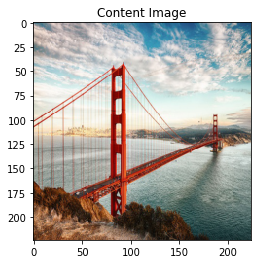

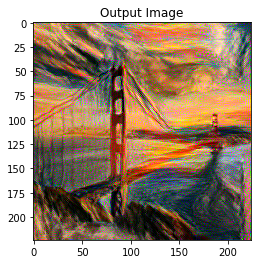

In [21]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(input_img, title='Output Image')
plt.ioff()
plt.show()

In [17]:
def imsave(tensor, path):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    image = unloader(img.data)
    image.save(path)

In [18]:
# imsave(input_img, '/home/zju/Documents/hjk/data/neural_style/output/bridge_pencil.jpg')